<a href="https://colab.research.google.com/github/MDAyesha/Twitter-Topic-Modeling-for-Customer-Reviews-of-Mobile-Phones/blob/main/Customer_Tweet_Reviews_of_Mobile_Phones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know',
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather',
                   'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

Import Dataset

In [ ]:
from google.colab import files
f1 = files.upload()

Saving Customer Tweet Reviews of Mobile Phone.csv to Customer Tweet Reviews of Mobile Phone.csv


In [ ]:
df = pd.read_csv('Customer Tweet Reviews of Mobile Phone.csv')
#df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)
df.head()

(25000, 3)


,ID,Tweet_Posted_Time (UTC),Tweet
0,1,01-05-18 0:47,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,01-05-18 4:11,Finally a transparant silicon case ^^ Thanks t...
2,3,01-05-18 4:19,We love this! Would you go? #talk #makememorie...
3,4,01-05-18 5:10,I'm wired I know I'm George I was made that wa...
4,5,01-05-18 5:29,What amazing service! Apple won't even talk to...


Tokenize tweets

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df.content = df['Tweet ']
df.content

0        #fingerprint #Pregnancy Test https://goo.gl/h1...
1        Finally a transparant silicon case ^^ Thanks t...
2        We love this! Would you go? #talk #makememorie...
3        I'm wired I know I'm George I was made that wa...
4        What amazing service! Apple won't even talk to...
                               ...                        
24995    How to Write Bangla without any Software in Sa...
24996    @hujodaddy1 Actually one of the reasons why I ...
24997          At Samsung Mobile — https://t.co/7Nd7RmPqsL
24998    Retweeted Samsung Mobile (@SamsungMobile): We'...
24999    Half of all Samsung mobile processors will go ...
Name: Tweet , Length: 25000, dtype: object

In [ ]:
# Convert to list
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', str(sent))  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['fingerprint', 'pregnancy', 'test', 'https', 'goo', 'gl', 'mfqv', 'android', 'apps', 'beautiful', 'cute', 'health', 'igers', 'iphoneonly', 'iphonesia', 'iphone']]


Build Bigram, Trigram & Lemmatize

In [ ]:
#!pip install -U spacy==2.1.3
import en_core_web_sm

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

Build Topic Model

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

/usr/local/lib/python3.10/dist-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


[(0,
  '0.033*"live" + 0.029*"present" + 0.028*"retweete" + 0.028*"moment" + '
  '0.027*"feb_proudly" + 0.023*"note" + 0.018*"car" + 0.014*"work" + '
  '0.014*"find" + 0.014*"announce"'),
 (1,
  '0.135*"new" + 0.061*"driver_made" + 0.029*"like_heaven" + 0.024*"buy" + '
  '0.022*"free" + 0.018*"edge" + 0.014*"full" + 0.013*"release" + '
  '0.013*"technology" + 0.011*"year"'),
 (2,
  '0.056*"co" + 0.040*"galaxy" + 0.035*"https" + 0.022*"samsung" + '
  '0.020*"today" + 0.018*"check" + 0.018*"investigate" + 0.015*"price" + '
  '0.014*"offer" + 0.013*"yndtzfh_vd"'),
 (3,
  '0.186*"phone" + 0.071*"mobile" + 0.056*"brand" + 0.043*"apple" + '
  '0.040*"profit" + 0.024*"capture" + 0.022*"scrap" + 0.016*"makers_battle" + '
  '0.015*"galaxys" + 0.010*"device"')]


Dominant Topics and contribution percentage

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Streaming output truncated to the last 5000 lines.
<ipython-input-45-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-45-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-45-bb79a6020bb1>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
<ipython-input-45-bb79a6020bb1>:15: FutureWarning: The frame.app

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.5659,"new, driver_made, like_heaven, buy, free, edge...","[fingerprint, pregnancy, test, android, app, b..."
1,1,2,0.5821,"co, galaxy, https, samsung, today, check, inve...","[finally, transparant, silicon, case, uncle, jm]"
2,2,2,0.4959,"co, galaxy, https, samsung, today, check, inve...","[love, talk, makememorie, relax]"
3,3,0,0.5057,"live, present, retweete, moment, feb_proudly, ...","[wire, way, iphone, cute]"
4,4,3,0.4669,"phone, mobile, brand, apple, profit, capture, ...","[amazing, service, apple, talk, question, pay,..."
5,5,3,0.8037,"phone, mobile, brand, apple, profit, capture, ...","[iphone, software, update, fuck, phone, big, t..."
6,6,2,0.8467,"co, galaxy, https, samsung, today, check, inve...","[happy, instapic, instadaily, com, qgfwlvj]"
7,7,1,0.6213,"new, driver_made, like_heaven, buy, free, edge...","[new, type, charger, cable, year, spectre, new..."
8,8,3,0.9119,"phone, mobile, brand, apple, profit, capture, ...","[bout, shopping, listening, music, iphone, jus..."
9,9,1,0.6364,"new, driver_made, like_heaven, buy, free, edge...","[photo, fun, pool, water, camera, picoftheday,..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9464,"live, present, retweete, moment, feb_proudly, note, car, work, find, announce","[puppy, rush, game, involve, cute, puppy, real, life, cute, pupsfollow, puppyrush, puppyrush, pu..."
1,1,0.9479,"new, driver_made, like_heaven, buy, free, edge, full, release, technology, year","[luck, yesterday, participate, amusing, contest, win, app, chance, win, multiple, mast_kalandar,..."
2,2,0.9587,"co, galaxy, https, samsung, today, check, investigate, price, offer, yndtzfh_vd","[butterfly, gift, www, zazzle, com, collection, butterfly_love, zazzle, com, sylrom, gift, sylro..."
3,3,0.9428,"phone, mobile, brand, apple, profit, capture, scrap, makers_battle, galaxys, device","[maverick, datum, sync, cloud, macworld, com, article, sync, contact, calendar, iphone, itune, m..."


Word Clouds

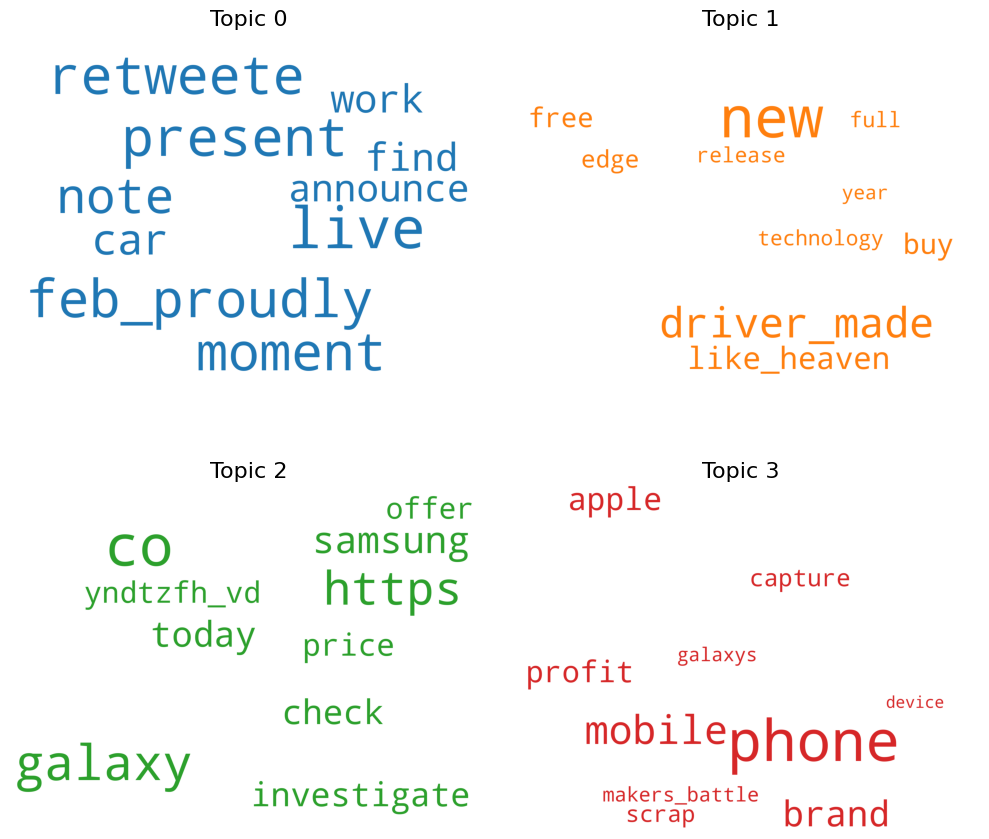

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<ipython-input-50-3105a4a9aef8>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


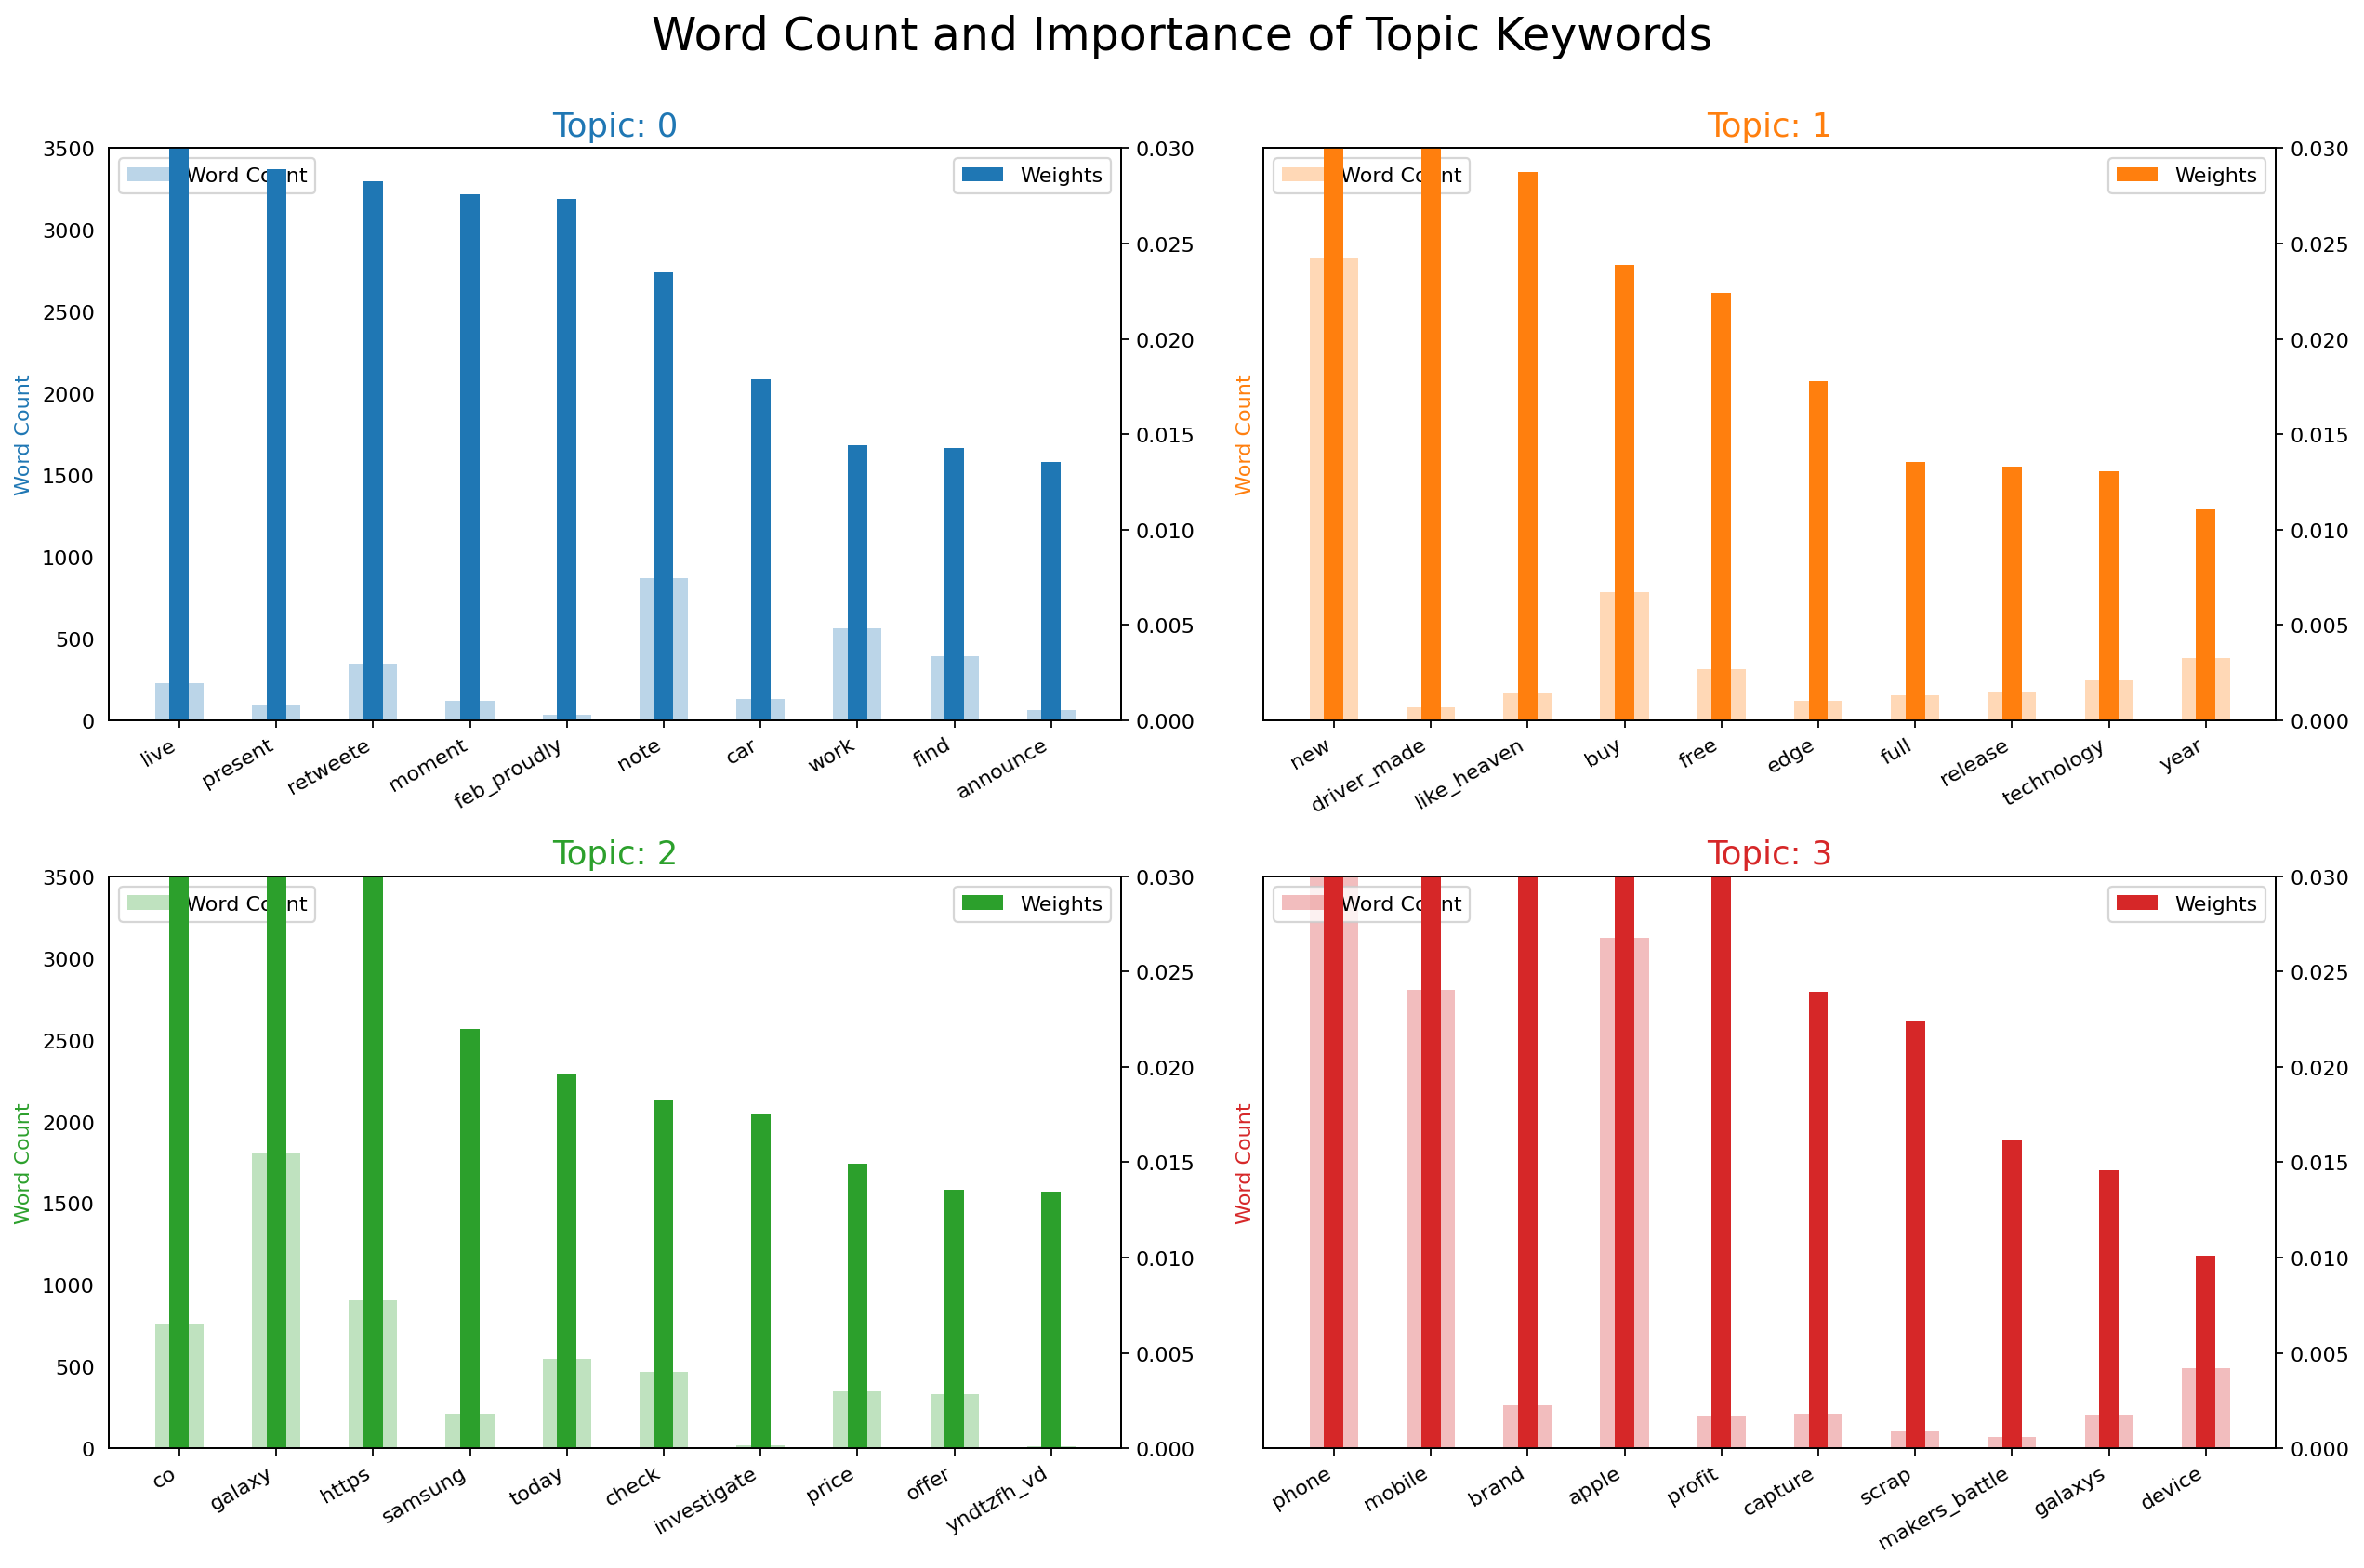

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

t-SNE Clustering

In [ ]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              width=900, height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23062 samples in 0.016s...
[t-SNE] Computed neighbors for 23062 samples in 0.494s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23062
[t-SNE] Computed conditional probabilities for sample 2000 / 23062
[t-SNE] Computed conditional probabilities for sample 3000 / 23062
[t-SNE] Computed conditional probabilities for sample 4000 / 23062
[t-SNE] Computed conditional probabilities for sample 5000 / 23062
[t-SNE] Computed conditional probabilities for sample 6000 / 23062
[t-SNE] Computed conditional probabilities for sample 7000 / 23062
[t-SNE] Computed conditional probabilities for sample 8000 / 23062
[t-SNE] Computed conditional probabilities for sample 9000 / 23062
[t-SNE] Computed conditional probabilities for sample 10000 / 23062
[t-SNE] Computed conditional probabilities for sample 11000 / 23062
[t-SNE] Computed conditional probabilities for sample 12000 / 23062
[t-SNE] Computed conditional probabilities for sam

pyLDAVis

In [ ]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dic=lda_model.id2word

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

In [ ]:
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.2
    Uninstalling pandas-2.1.2:
      Successfully uninstalled pandas-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=dic)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.304005 -0.099593       1        1  31.036283
2     -0.163222 -0.196971       2        1  23.799326
0     -0.155685  0.036889       3        1  23.500564
1      0.014902  0.259675       4        1  21.663827, topic_info=              Term         Freq        Total Category  logprob  loglift
31           phone  8757.000000  8757.000000  Default  30.0000  30.0000
42             new  4438.000000  4438.000000  Default  29.0000  29.0000
376         mobile  3362.000000  3362.000000  Default  28.0000  28.0000
3128         brand  2645.000000  2645.000000  Default  27.0000  27.0000
2840            co  2024.000000  2024.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
19242  driver_made  1997.539526  2472.362768   Topic4  -2.7997   1.3163
655           open   173.300478   178.538845   Topic4  -5.2443   1.4997
19346        probe   166.396426   170.522984   Topic4  -5.2849   1.5050
1263       capture   353.026642  1480.318165   Topic4  -4.5328   0.0961
9217        unveil   181.527440   354.274767   Topic4  -5.1979   0.8609

[181 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
13677      1  0.997703  added_video
22         2  0.992008      amazing
0          4  0.991503      android
1860       3  0.998518     announce
1          4  0.996959          app
...      ...       ...          ...
629        1  0.995440         well
452        4  0.994355          win
92         3  0.998705         work
50         4  0.996258         year
19079      2  0.996695   yndtzfh_vd

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])